Total number of observations: 6759
Low incone                  : 1161
Medium income               : 2124
High income                 : 2907


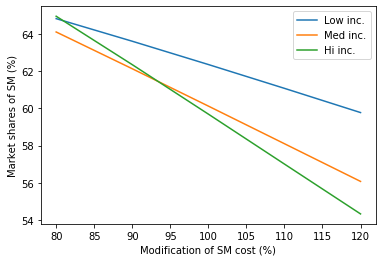

In [2]:
# Translated to .py by Marti Montesinos
# Adapted to PandasBiogeme by Michel Bierlaire
# Wed Oct 31 21:38:00 2018

import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.models import logit
from biogeme.expressions import Beta, DefineVariable, log
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("swissmetro.dat",'\t')
database = db.Database("swissmetro",df)
pd.options.display.float_format = '{:.3g}'.format
globals().update(database.variables)


exclude = ((  PURPOSE   !=  1  ) * (  PURPOSE   !=  3  ) + (  CHOICE   ==  0  )  + (  AGE == 6  ))>0
database.remove(exclude)

#Parameters to be estimated
# Arguments:
#   1  Name for report. Typically, the same as the variable
#   2  Starting value
#   3  Lower bound
#   4  Upper bound
#   5  0: estimate the parameter, 1: keep it fixed
ASC_CAR	 = Beta('ASC_CAR',0,None,None,0)
ASC_SBB	 = Beta('ASC_SBB',0,None,None,1)
ASC_SM	 = Beta('ASC_SM',0,None,None,0)
B_CAR_COST	 = Beta('B_CAR_COST',0,None,None,0)
B_HE	 = Beta('B_HE',0,None,None,0)
B_SM_COST	 = Beta('B_SM_COST',0,None,None,0)
B_TIME	 = Beta('B_TIME',0,None,None,0)
B_TRAIN_COST	 = Beta('B_TRAIN_COST',0,None,None,0)
B_SENIOR	 = Beta('B_SENIOR',0,None,None,0)
B_GA	 = Beta('B_GA',0,None,None,0)

# Define here arithmetic expressions for name that are not directly 
# available from the data

SENIOR  = DefineVariable('SENIOR', AGE   ==  5 ,database)
CAR_AV_SP  = DefineVariable('CAR_AV_SP', CAR_AV    *  (  SP   !=  0  ),database)
SM_COST  = DefineVariable('SM_COST', SM_CO   * (  GA   ==  0  ),database)
TRAIN_AV_SP  = DefineVariable('TRAIN_AV_SP', TRAIN_AV    *  (  SP   !=  0  ),database)
TRAIN_COST  = DefineVariable('TRAIN_COST', TRAIN_CO   * (  GA   ==  0  ),database)

TRAIN_TT_SCALED = DefineVariable('TRAIN_TT_SCALED',\
                                 TRAIN_TT / 100.0,database)
TRAIN_COST_SCALED = DefineVariable('TRAIN_COST_SCALED',\
                                   TRAIN_COST / 100,database)
SM_TT_SCALED = DefineVariable('SM_TT_SCALED', SM_TT / 100.0,database)
SM_COST_SCALED = DefineVariable('SM_COST_SCALED', SM_COST / 100,database)
CAR_TT_SCALED = DefineVariable('CAR_TT_SCALED', CAR_TT / 100,database)
CAR_CO_SCALED = DefineVariable('CAR_CO_SCALED', CAR_CO / 100,database)
TRAIN_HE_SCALED = DefineVariable('TRAIN_HE_SCALED', TRAIN_HE / 100,database)
SM_HE_SCALED = DefineVariable('SM_HE_SCALED', SM_HE / 100,database)


#Utilities
Car_SP = ASC_CAR + B_TIME * CAR_TT_SCALED + B_CAR_COST * CAR_CO_SCALED + B_SENIOR * SENIOR
SBB_SP = ASC_SBB + B_TIME * TRAIN_TT_SCALED + B_TRAIN_COST * TRAIN_COST_SCALED + B_HE * TRAIN_HE_SCALED + B_GA * GA
SM_SP = ASC_SM + B_TIME * SM_TT_SCALED + B_SM_COST * SM_COST_SCALED + B_HE * SM_HE_SCALED + B_GA * GA + B_SENIOR * SENIOR


V = {3: Car_SP,1: SBB_SP,2: SM_SP}

av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

# The choice model is a logit, with availability conditions
logprob = models.loglogit(V,av,CHOICE)
biogeme  = bio.BIOGEME(database,logprob)
biogeme.modelName = "logit_SM_specific"
results = biogeme.estimate()

# Duplicate the database
database_lowInc = db.Database("swissmetro_lowInc",pd.DataFrame.copy(database.data))
database_medInc = db.Database("swissmetro_medInc",pd.DataFrame.copy(database.data))
database_highInc = db.Database("swissmetro_highInc",pd.DataFrame.copy(database.data))

# Remove observations
database_lowInc.remove((INCOME != 0) * (INCOME != 1))
database_medInc.remove(INCOME != 2)
database_highInc.remove(INCOME != 3)
print(f"Total number of observations: {database.getNumberOfObservations()}")
print(f"Low incone                  : {database_lowInc.getNumberOfObservations()}")
print(f"Medium income               : {database_medInc.getNumberOfObservations()}")
print(f"High income                 : {database_highInc.getNumberOfObservations()}")



# Function that calculates the market shares for SM for a given scaling of the cost

def scenario(costScale,database):
    SM_SP = ASC_SM + B_TIME * SM_TT_SCALED + B_SM_COST * SM_COST_SCALED * costScale + B_HE * SM_HE_SCALED + B_GA * GA + B_SENIOR * SENIOR
    V = {3: Car_SP,1: SBB_SP,2: SM_SP}
    prob_SM = logit(V,av,2)
    simulate = {'Prob. SM': prob_SM}
    biosim  = bio.BIOGEME(database,simulate)
    biosim.modelName = f"marketShares_SM_{costScale}"
    simresults = biosim.simulate(dict(zip(results.data.betaNames, results.data.betaValues)))
    return 100*simresults['Prob. SM'].mean()

#scales = np.arange(0.1,2.1,0.1)
scales = np.arange(0.8,1.3,0.1)
shares_low = [scenario(s,database_lowInc) for s in scales]
shares_med = [scenario(s,database_medInc) for s in scales]
shares_hi = [scenario(s,database_highInc) for s in scales]

fig, ax = plt.subplots()
ax.plot(100*scales,shares_low,label='Low inc.')
ax.plot(100*scales,shares_med,label='Med inc.')
ax.plot(100*scales,shares_hi,label='Hi inc.')
ax.legend()
plt.xlabel("Modification of SM cost (%)")
plt.ylabel("Market shares of SM (%)")
plt.show()
